In [1]:
import tensorflow as tf
import numpy as np
import librosa

import pandas as pd
import numpy as np
import soundfile as sf
import os

In [2]:
if os.path.exists("ESC-50-master") == False:
  !wget https://github.com/karoldvl/ESC-50/archive/master.zip
  !unzip master.zip

Define helper functions for normalize audio and split audio tracks

In [3]:
def normalize_audio(S):
    R = librosa.power_to_db(np.copy(S))
    R -= np.min(R)
    R =  R / (np.max(np.abs(R)) + 1.0)
    return R

def split_audio_track(X, window = 0.5, overlap = 0.5):
    result = []

    xshape = X.shape[0]
    chunk = int(xshape * window)
    offset = int(chunk * (1.0 - overlap))
    
    spitted_tracks = [X[i:i + chunk] for i in range(0, xshape - chunk + offset, offset)]
    for sub_track in spitted_tracks:
        result.append(sub_track)

    return np.array(result)

I'm using **SoundFile** for loading audio data, because libRosa mighgt using different backend for loading audio data with differnet results.

In [4]:
def load_spectrograms(file_path):
    signal, sr = sf.read(file_path, dtype=np.float32)

    signal_length = len(signal)
    signal = signal[:signal_length]

    signals = split_audio_track(signal)
    array_result = []
    last_shape = None
    for x in signals:
        spec = librosa.feature.melspectrogram(x, n_fft = 1024, hop_length = 512)[:,:,np.newaxis]
        if spec.shape == (128, 216, 1):
            normalized_spec = normalize_audio(spec)
            if last_shape is None or last_shape == normalized_spec.shape:
              array_result.extend(np.array([normalized_spec]))
              last_shape = normalized_spec.shape

    return np.array(array_result)

In [5]:
data_frame = pd.read_csv("ESC-50-master/meta/esc50.csv")
data_frame['category_index'] = pd.to_numeric(data_frame['category'], errors='coerce')
int2str = dict(enumerate(data_frame['category'].array))
str2int = dict(zip(int2str.values(), int2str.keys()))
data_frame['category_index'] = list(map(lambda x: str2int[x], data_frame['category'].array))
data_frame

,filename,fold,target,category,esc10,src_file,take,category_index
0,1-100032-A-0.wav,1,0,dog,True,100032,A,1999
1,1-100038-A-14.wav,1,14,chirping_birds,False,100038,A,1972
2,1-100210-A-36.wav,1,36,vacuum_cleaner,False,100210,A,1996
3,1-100210-B-36.wav,1,36,vacuum_cleaner,False,100210,B,1996
4,1-101296-A-19.wav,1,19,thunderstorm,False,101296,A,1715
...,...,...,...,...,...,...,...,...
1995,5-263831-B-6.wav,5,6,hen,False,263831,B,1995
1996,5-263902-A-36.wav,5,36,vacuum_cleaner,False,263902,A,1996
1997,5-51149-A-25.wav,5,25,footsteps,False,51149,A,1997
1998,5-61635-A-8.wav,5,8,sheep,False,61635,A,1998


In [6]:
ar, _ = sf.read("./ESC-50-master/audio/5-9032-A-0.wav", dtype=np.float32)
print("Frame Length: {}".format(split_audio_track(ar).shape))

Frame Length: (3, 110250)


In [7]:
librosa.feature.melspectrogram(split_audio_track(ar)[0], n_fft = 1024, hop_length = 512).shape

(128, 216)

In [8]:
split_audio_track(ar).shape

(3, 110250)

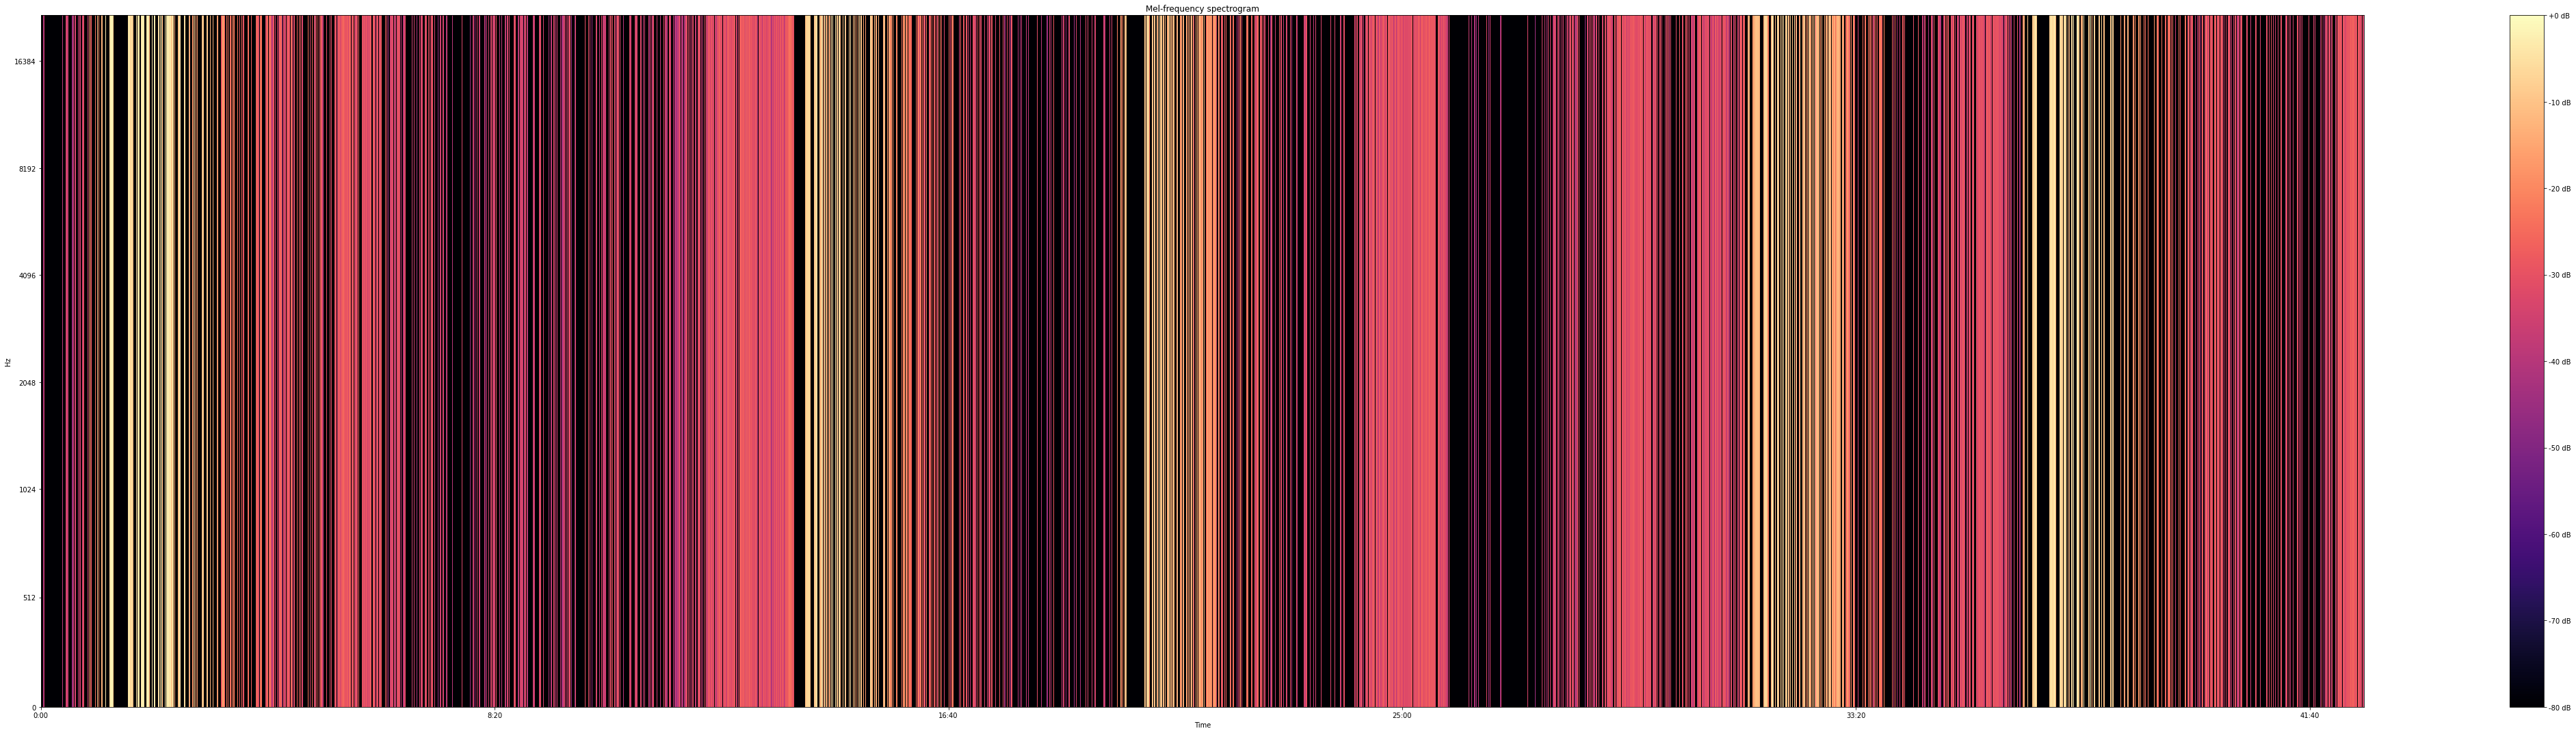

In [9]:
import matplotlib
import matplotlib.pyplot as plt
import librosa.display

%matplotlib inline
plt.figure(figsize=(60, 15))
S_dB = librosa.power_to_db(split_audio_track(ar)[0][..., np.newaxis].T, ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',  y_axis='mel', fmax=22050)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [10]:
folder_path = './ESC-50-master/audio/'
arr_specs = []
arr_category = []

for index, row in data_frame.iterrows():
    target = row['target']
    category = row['category']
    path = folder_path + row['filename']

    if os.path.exists(path):
      specs = load_spectrograms(path)
      
      if len(specs) > 0:
        arr_category.extend(np.full(len(specs), target))
        arr_specs.extend(specs)
            
        print('Path: {} \tTarget: {}'.format(path, target))

Path: ./ESC-50-master/audio/1-100032-A-0.wav 	Target: 0
Path: ./ESC-50-master/audio/1-100038-A-14.wav 	Target: 14
Path: ./ESC-50-master/audio/1-100210-A-36.wav 	Target: 36
Path: ./ESC-50-master/audio/1-100210-B-36.wav 	Target: 36
Path: ./ESC-50-master/audio/1-101296-A-19.wav 	Target: 19
Path: ./ESC-50-master/audio/1-101296-B-19.wav 	Target: 19
Path: ./ESC-50-master/audio/1-101336-A-30.wav 	Target: 30
Path: ./ESC-50-master/audio/1-101404-A-34.wav 	Target: 34
Path: ./ESC-50-master/audio/1-103298-A-9.wav 	Target: 9
Path: ./ESC-50-master/audio/1-103995-A-30.wav 	Target: 30
Path: ./ESC-50-master/audio/1-103999-A-30.wav 	Target: 30
Path: ./ESC-50-master/audio/1-104089-A-22.wav 	Target: 22
Path: ./ESC-50-master/audio/1-104089-B-22.wav 	Target: 22
Path: ./ESC-50-master/audio/1-105224-A-22.wav 	Target: 22
Path: ./ESC-50-master/audio/1-110389-A-0.wav 	Target: 0
Path: ./ESC-50-master/audio/1-110537-A-22.wav 	Target: 22
Path: ./ESC-50-master/audio/1-115521-A-19.wav 	Target: 19
Path: ./ESC-50-maste

In [11]:
X, y = np.array(arr_specs), np.array(arr_category)

In [12]:
X.shape, y.shape

((6000, 128, 216, 1), (6000,))

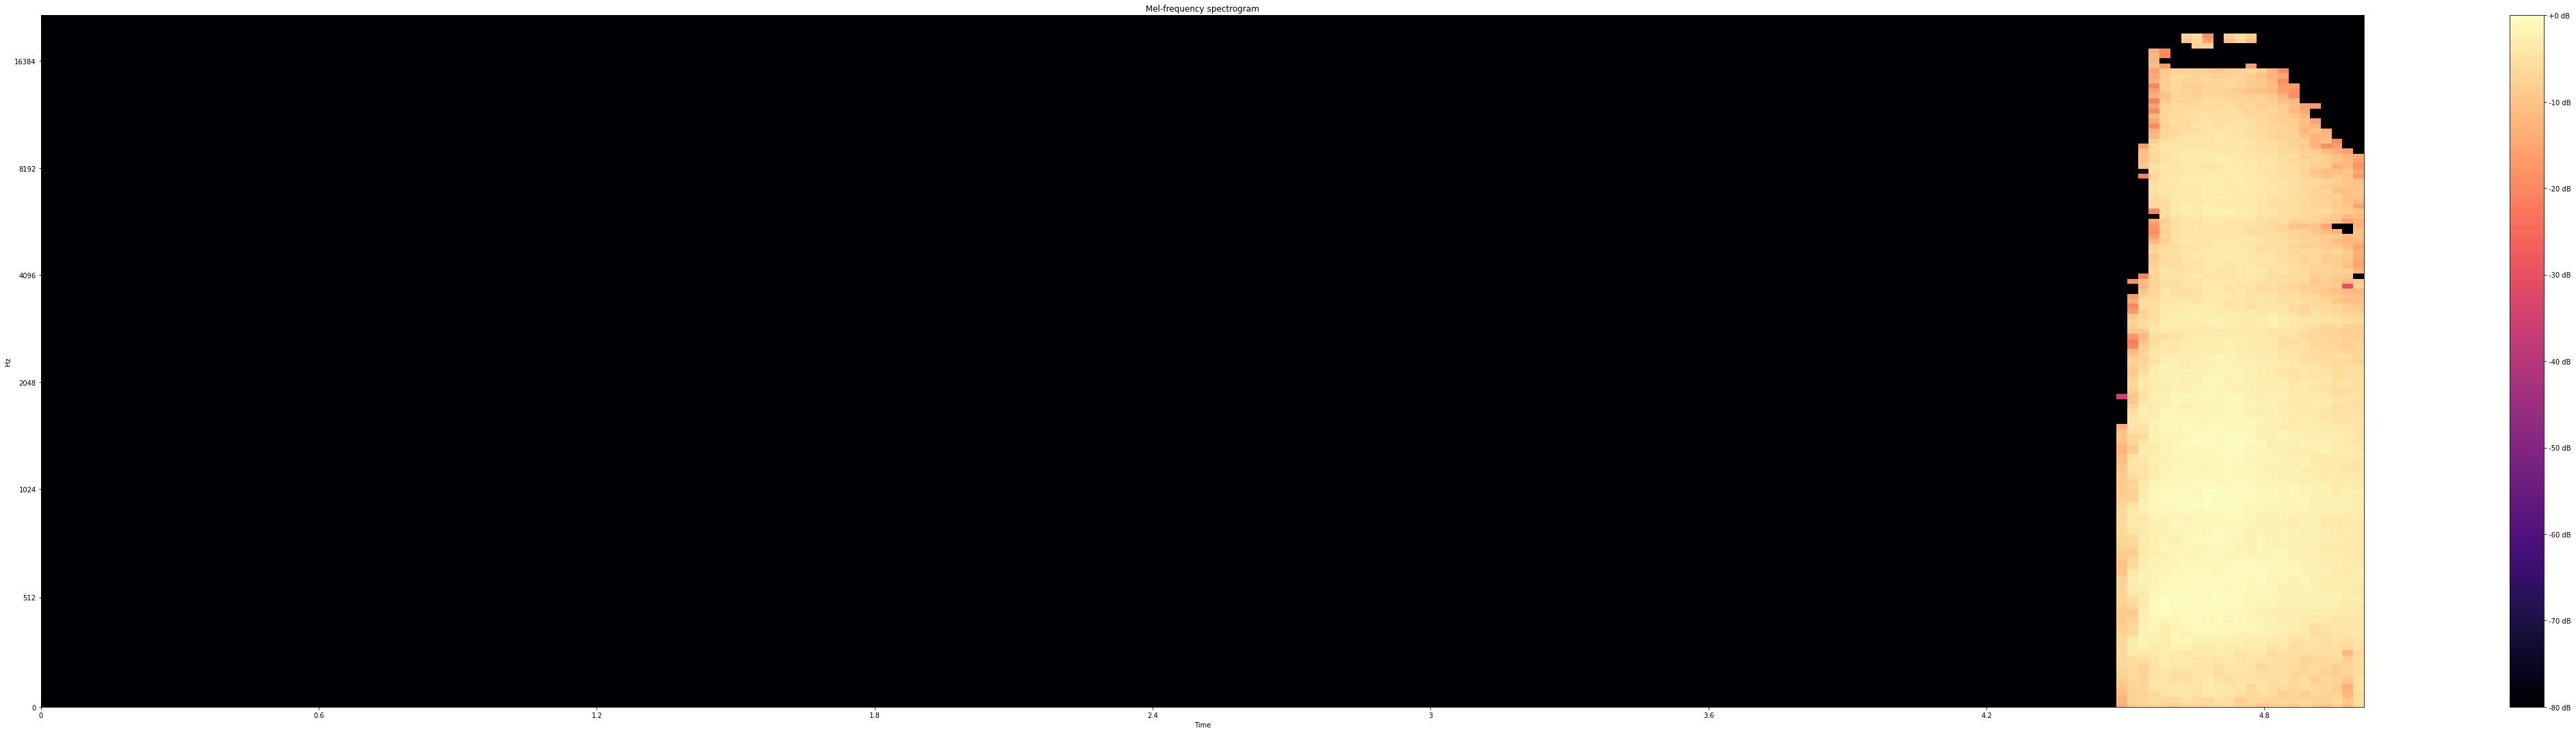

In [13]:
import matplotlib
import matplotlib.pyplot as plt
import librosa.display

%matplotlib inline
plt.figure(figsize=(60, 15))
S_dB = librosa.power_to_db(arr_specs[0][:,:, -1], ref=np.max)
librosa.display.specshow(S_dB, x_axis='time',  y_axis='mel', fmax=22050)
plt.colorbar(format='%+2.0f dB')
plt.title('Mel-frequency spectrogram')
plt.tight_layout()
plt.show()

In [14]:
import tensorflow as tf

In [15]:
y_categorical = tf.keras.utils.to_categorical(y)

In [16]:
from sklearn.model_selection import train_test_split

In [17]:
X_train, X_valid, y_train, y_valid = train_test_split(X, y_categorical, test_size=0.1, random_state=42, stratify = y_categorical)

In [18]:
X.shape

(6000, 128, 216, 1)

In [19]:
input_shape = (X[0].shape)

In [20]:
input_shape

(128, 216, 1)

In [21]:
num_categories = y_categorical.shape[1]

In [22]:
model = tf.keras.Sequential()

# Conv Block 1
model.add(tf.keras.layers.Conv2D(16, kernel_size=(3, 3), strides=(1, 1),
                 activation='relu', input_shape=input_shape))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Conv Block 2
model.add(tf.keras.layers.Conv2D(32, (3, 3), strides=(1, 1), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Conv Block 3
model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Conv Block 4
model.add(tf.keras.layers.Conv2D(128, (3, 3), strides=(1, 1), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# Conv Block 5
model.add(tf.keras.layers.Conv2D(64, (3, 3), strides=(1, 1), activation='relu'))
model.add(tf.keras.layers.BatchNormalization())
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))

# MLP
model.add(tf.keras.layers.Flatten())

model.add(tf.keras.layers.Dense(num_categories, activation='softmax'))

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 214, 16)      160       
                                                                 
 batch_normalization (BatchN  (None, 126, 214, 16)     64        
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 107, 16)      0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 105, 32)       4640      
                                                                 
 batch_normalization_1 (Batc  (None, 61, 105, 32)      128       
 hNormalization)                                                 
                                                        

In [24]:
model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adam(),
              metrics=['accuracy'])

In [25]:
history = model.fit(X_train, y_train, validation_data=(X_valid, y_valid), 
          batch_size=32,
          epochs=30)

Epoch 1/30
169/169 [==============================] - 6s 20ms/step - loss: 2.9682 - accuracy: 0.2365 - val_loss: 5.5195 - val_accuracy: 0.0200
Epoch 2/30
169/169 [==============================] - 3s 16ms/step - loss: 1.9047 - accuracy: 0.4646 - val_loss: 6.3355 - val_accuracy: 0.0367
Epoch 3/30
169/169 [==============================] - 3s 17ms/step - loss: 1.4264 - accuracy: 0.5911 - val_loss: 3.8976 - val_accuracy: 0.1733
Epoch 4/30
169/169 [==============================] - 3s 17ms/step - loss: 1.1129 - accuracy: 0.6930 - val_loss: 1.9124 - val_accuracy: 0.4917
Epoch 5/30
169/169 [==============================] - 3s 18ms/step - loss: 0.8899 - accuracy: 0.7461 - val_loss: 1.6822 - val_accuracy: 0.5433
Epoch 6/30
169/169 [==============================] - 3s 19ms/step - loss: 0.7256 - accuracy: 0.7965 - val_loss: 3.3228 - val_accuracy: 0.3750
Epoch 7/30
169/169 [==============================] - 3s 20ms/step - loss: 0.5877 - accuracy: 0.8363 - val_loss: 1.9503 - val_accuracy: 0.5167

In [26]:
loss = history.history['loss']
val_loss = history.history['val_loss']

<Figure size 432x288 with 0 Axes>

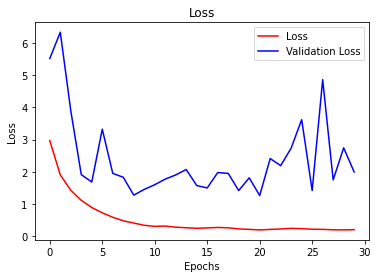

<Figure size 432x288 with 0 Axes>

In [27]:
import matplotlib.image  as mpimg
import matplotlib.pyplot as plt

epochs=range(len(loss))

plt.plot(epochs, loss, 'r')
plt.plot(epochs, val_loss, 'b')
plt.title('Loss')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend(["Loss", "Validation Loss"])

plt.figure()

In [28]:
model.save_weights('./SoundClassification.h5')

In [29]:
!pip install coremltools -U

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [30]:
import coremltools
coreml_model = coremltools.convert(model)
coreml_model.author = 'Dmytro Hrebeniuk'
coreml_model.short_description = 'Sound Type recognition'

coreml_model.save('SoundRecognition.mlmodel')  

Translating MIL ==> NeuralNetwork Ops: 100%|██████████| 116/116 [00:00<00:00, 4909.63 ops/s]
